Copyright (C) Egon Kidmose 2015-2017

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.


In [4]:
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
m_files = [
    'output/20161228-160556-js3/20161228-160556-js3-metrics.pickle',
    'output/20161228-165058-js3/20161228-165058-js3-metrics.pickle',
    'output/20161228-173816-js3/20161228-173816-js3-metrics.pickle',
    'output/20161228-182419-js3/20161228-182419-js3-metrics.pickle',
    'output/20161228-190939-js3/20161228-190939-js3-metrics.pickle',
    'output/20161228-195657-js3/20161228-195657-js3-metrics.pickle',
    'output/20161228-204147-js3/20161228-204147-js3-metrics.pickle',
    'output/20161228-212834-js3/20161228-212834-js3-metrics.pickle',
    'output/20161228-221359-js3/20161228-221359-js3-metrics.pickle',
    'output/20161228-225859-js3/20161228-225859-js3-metrics.pickle',
]

def load_pickle(filename):
    with open(filename, 'r') as f:
        return pickle.load(f)

ms = map(load_pickle, m_files)

In [6]:
ps = (5,2) # parameters for clustering, eps=0.03, minPts=10

In [7]:
def aggregate(df):
    return pd.concat(
        [
            df.mean().rename('Mean'),
            df.min().rename('Min.'),
            df.max().rename('Max.'),
        ],
        axis=1,
    )

In [8]:
# Domain specific metrics
df_domain = pd.concat([
        pd.Series([m['imr']['validation'][ps] for m in ms], name='imr'),
        pd.Series([m['arf']['validation'][ps] for m in ms], name='arf'),
        pd.Series([m['narf']['validation'][ps] for m in ms], name='narf'),
    ], axis=1,
)
df_domain_agg = aggregate(df_domain)
df_domain_agg

,Mean,Min.,Max.
imr,0.006183,0.000000,0.017857
arf,9.247887,8.307692,9.818182
narf,0.019154,0.016955,0.020460


In [9]:
# Classification metrics
df_classify = pd.concat([
        pd.Series([m['accuracy']['validation'][ps] for m in ms], name='Accuracy'),
        pd.Series([m['precision']['validation'][ps] for m in ms], name='Precision'),
        pd.Series([m['recall']['validation'][ps] for m in ms], name='Recall'),
        pd.Series([m['f1']['validation'][ps] for m in ms], name='F1-score'),
    ], axis=1,
)
df_classify_agg = aggregate(df_classify)
df_classify_agg

,Mean,Min.,Max.
Accuracy,0.737024,0.716937,0.759259
Precision,0.731029,0.709876,0.752146
Recall,0.737024,0.716937,0.759259
F1-score,0.720023,0.702132,0.740864


In [10]:
# Classification metrics, breakdown pr. class
dfs_class_classify = [
    (pd.DataFrame(dict(m['per_class']['validation'][ps].items())), rep) 
    for rep, m in enumerate(ms)
]
df_class_classify = pd.concat(map(
    lambda (df, rep) : pd.concat([
            df,
            pd.Series([rep for x in range(len(df.index))], index=df.index, name='repetition')
        ], axis=1),
    dfs_class_classify
)).reset_index(drop=True)
df_class_classify.loc[df_class_classify['labels']==-1, 'labels'] = 'Benign'

# df_class_classify_agg = aggregate(df_class_classify[['precission', 'recall', 'f1', 'support']])
# df_class_classify_agg

df_class_classify_agg = df_class_classify[
    ['f1', 'precission', 'recall', 'support', 'labels']
].groupby(
    'labels'
).aggregate(
    ['mean', 'min', 'max']
)
df_class_classify_agg = pd.concat([
        df_class_classify_agg.reset_index(),
        df_class_classify[
            ['f1', 'precission', 'recall', 'support']
        ].groupby(
            lambda _ : 'Overall'
        ).agg(
            ['mean', 'min', 'max']
        ).reset_index().rename(columns={'index':'labels'})
]).set_index('labels')
df_class_classify_agg

f1                     precission                      \
             mean       min       max       mean       min       max   
labels                                                                 
1        0.445343  0.153846  0.700000   0.612500  0.333333  0.800000   
2        0.758291  0.551724  0.857143   0.836327  0.727273  1.000000   
3        0.985266  0.965517  1.000000   0.983826  0.935484  1.000000   
4        0.886559  0.800000  0.968750   0.888908  0.756757  1.000000   
5        0.650706  0.589474  0.727273   0.554026  0.500000  0.645833   
6        0.285798  0.218182  0.400000   0.557998  0.333333  0.875000   
7        0.451951  0.357143  0.541176   0.495430  0.357143  0.575758   
Benign   0.812333  0.786667  0.835886   0.778319  0.751037  0.803653   
Overall  0.659531  0.153846  1.000000   0.713417  0.333333  1.000000   

           recall                     support            
             mean       min       max    mean  min  max  
labels                                                   
1        0.370000  0.100000  0.700000   10.00   10   10  
2        0.700877  0.444444  0.833333   18.40   18   19  
3        0.987171  0.965517  1.000000   31.70   29   34  
4        0.893466  0.757576  1.000000   32.80   32   33  
5        0.792308  0.717949  0.923077   39.00   39   39  
6        0.197372  0.150000  0.275000   39.50   39   40  
7        0.421774  0.319149  0.534884   44.40   42   47  
Benign   0.850362  0.814815  0.906977  215.80  215  216  
Overall  0.651666  0.100000  1.000000   53.95   10  216

/home/egk/git-reps/ids-setup/correlation/neural-network/env27/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


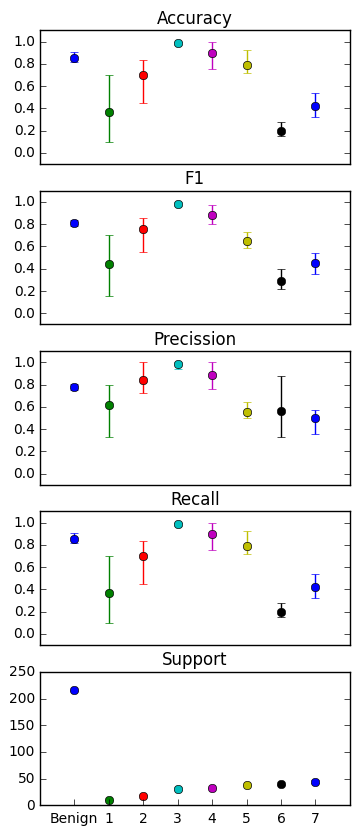

In [11]:
ylims = {
    'support': [0, 250],
}

fig, axs = plt.subplots(nrows=5, ncols=1,figsize=(4, 10))
for metric, ax in zip(['Accuracy', 'F1', 'Precission', 'Recall', 'Support',], axs):
    for i, incident in enumerate(df_class_classify['labels'].unique().tolist()):
        y = np.array(df_class_classify[df_class_classify['labels'] == incident][metric.lower()].tolist())
        x = np.ones_like(y)*i
        #ax.plot(x, y, 'x', markersize=5)
        ax.errorbar(
            i,
            y.mean(),
            yerr=[[y.mean()-y.min()], [y.max()-y.mean()]],
            fmt='--o',
        )
        ax.set_ylim(ylims.get(metric.lower(), [-0.1, 1.1]))
        ax.set_xlim([-1, 8])
        ax.set_title(metric)
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
    
axs[-1].tick_params(axis='x', which='major', bottom='on', top='off', labelbottom='on') 
axs[-1].set_xticklabels([''] + df_class_classify['labels'].unique().tolist() + [''])
plt.show()

In [23]:
res = """\\begin{tikzpicture}\n"""
for i, metric in enumerate(['Accuracy', 'F1', 'Precission', 'Recall', 'Support',]):
    res += """\\begin{{axis}}[
    title={{{metric}}},
    name={name},
    height=4cm, width=8cm,
    {ylims}
    {ticks}
    {at}
  ]
  \\addplot+[
    only marks,
    black, mark options={{solid,fill=black}},
    error bars/.cd,
    y dir=both,y explicit
  ]
  coordinates {{\n""".format(
            metric=metric,
            name='ax'+str(i),
            at=('at=(ax'+str(i-1)+'.below south west), anchor=above north west,' if i>0 else '%'),
            ticks=('xmajorticks=false,' if metric!='Support'
                   else 'xtick={0,1,2,3,4,5,6,7,8,9}, xticklabels={Benign, 1, 2, 3, 4, 5, 6, 7, 8},'),
            ylims=('ymin=-0.1,ymax=1.1,' if metric!='Support' else 'ymin=0,ymax=250,'),
        )
    for x, incident in enumerate(df_class_classify['labels'].unique().tolist()):
        y = np.array(df_class_classify[df_class_classify['labels'] == incident][metric.lower()].tolist())
        res += "    ({},{}) -= (0,{}) += (0,{})\n".format(
                x, y.mean(), y.mean()-y.min(), y.max()-y.mean()
        )
    res += """   };
\end{axis}
"""
res += """\\end{tikzpicture}"""
with open('/home/egk/paper-reps/correlation2/figures/classification_tikz.tex', 'w') as f:
    f.write(res)

In [13]:
# confusion matrix
print(sum([m['cm_inc_inc']['validation'][ps] for m in ms]).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  benign &   1 &    2 &    3 &    4 &    5 &   6 &    7 \\
\midrule
benign &    1835 &  10 &    9 &    4 &   31 &  107 &  36 &  126 \\
1      &      51 &  37 &    1 &    0 &    1 &    2 &   5 &    3 \\
2      &      27 &   0 &  129 &    1 &    0 &   26 &   1 &    0 \\
3      &       4 &   0 &    0 &  313 &    0 &    0 &   0 &    0 \\
4      &      11 &   1 &    0 &    0 &  293 &   15 &   7 &    1 \\
5      &      29 &   1 &    0 &    0 &    0 &  309 &   5 &   46 \\
6      &     183 &   9 &    8 &    0 &    4 &   93 &  78 &   20 \\
7      &     219 &   0 &    8 &    0 &    4 &    8 &  18 &  187 \\
\bottomrule
\end{tabular}



In [14]:
# Classification metrics
df_classify = pd.concat([
        pd.Series([m['n_clusters']['validation'][ps] for m in ms], name='Clusters'),
        pd.Series([m['homogenity']['validation'][ps] for m in ms], name='Homogenity'),
        pd.Series([m['outliers']['validation'][ps] for m in ms], name='Outliers'),
        pd.Series([m['faro']['validation'][ps] for m in ms], name='FAR in outliers'),
        pd.Series([m['farc']['validation'][ps] for m in ms], name='FAR in clusters'),
    ], axis=1,
)
df_classify_agg = aggregate(df_classify)
df_classify_agg

,Mean,Min.,Max.
Clusters,45.800000,43.000000,51.000000
Homogenity,0.641933,0.623578,0.674763
Outliers,88.100000,70.000000,101.000000
FAR in outliers,0.440202,0.340909,0.495050
FAR in clusters,0.514964,0.501511,0.542274


In [15]:
set(np.array([m['cm_inc_inc']['validation'][ps].as_matrix() for m in ms]).sum(axis=1).sum(axis=1))

{431, 432}